# SEIS-763 Group Project include group member names with an introduction explaining what problem we are solving (NEEDS REVISION)
- We are a state program that provides low interest loans to low income family.
- The maximum amount that we are allowed to approve on a loan up to $300,000
- Default rates tend to be high and we have a limited budget, therefore our goal is to maximize the amount allocated to our agency by predicting home values based on a multitude of different predictors in order to best mitigate loss if a home goes into default and maximize purchasing power to help as many families as possible.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1. Data Cleaning/Imputation



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

In [3]:
# Load data
file_path_train = '/content/drive/MyDrive/train.csv'
file_path_test = '/content/drive/MyDrive/test.csv'
df1 = pd.read_csv(file_path_train)
df2 = pd.read_csv(file_path_test)

# Combine (stack) them vertically, one after the other
df = pd.concat([df1, df2], ignore_index=True)

In [4]:
num_rows = df.shape
print(f"Number of rows in the dataset: {num_rows}")
print(df.head())

Number of rows in the dataset: (2919, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCo

In [5]:
# Drop duplicates
df = df.drop_duplicates()
print("After dropping duplicates: The number of rows: ", df.shape)

After dropping duplicates: The number of rows:  (2919, 81)


In [6]:
# Show initial missing data
total_missing = df.isnull().sum().sum()
print(f"Total missing values before imputation: {total_missing}")

Total missing values before imputation: 17166


### Heat Map of missing values prior to Imputation

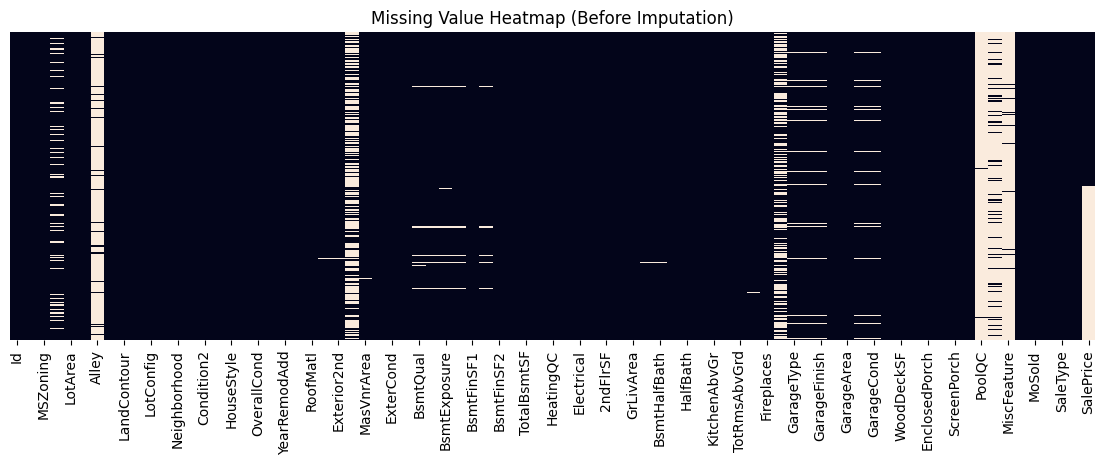

In [7]:
# 1. Missing Value Heatmap
plt.figure(figsize=(14,4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Value Heatmap (Before Imputation)')
plt.show()


### Drop any rows that are missing a 'SalePrice' value prior to classification

In [8]:
df = df.dropna(subset=['SalePrice'])
print(df.shape)


(1460, 81)


In [9]:
# Separate numeric & categorical
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [10]:
# Ordinal encode categorical data (KNN needs numeric input)
encoder = OrdinalEncoder()
encoded_cats = encoder.fit_transform(df[cat_cols])

# Combine numeric and encoded categorical
combined = np.hstack((df[numeric_cols], encoded_cats))

## Regression VS Classificaiton of the Target (SalePrice)

### Histogram of SalePrice Prior to Trimming Data Set based on the Business Requirements
- Useful when determining the skew of data outliers
- Paticularly useful when applying classification to the numeric target

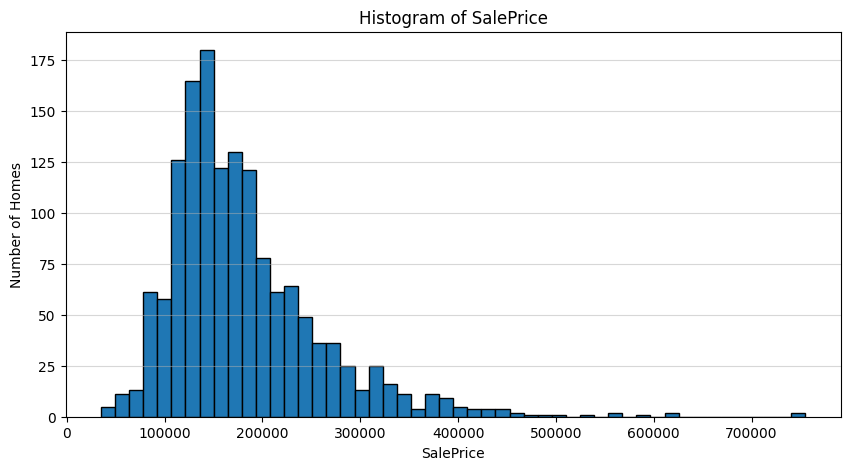

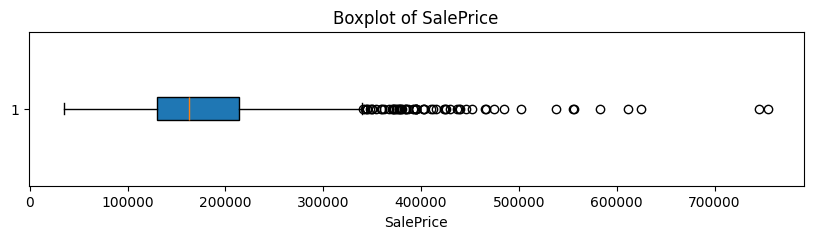

In [11]:
# Plot a histogram of SalePrice
plt.figure(figsize=(10, 5))
plt.hist(df['SalePrice'], bins=50, edgecolor='black')
plt.title('Histogram of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Number of Homes')
plt.grid(axis='y', alpha=0.5)
plt.show()

# Plot a boxplot of SalePrice
plt.figure(figsize=(10, 2))
plt.boxplot(df['SalePrice'], vert=False, patch_artist=True)
plt.title('Boxplot of SalePrice')
plt.xlabel('SalePrice')
plt.show()


### Log SalePrice
- Useful for shrinking outliers if using regression ans SalePrice as your target

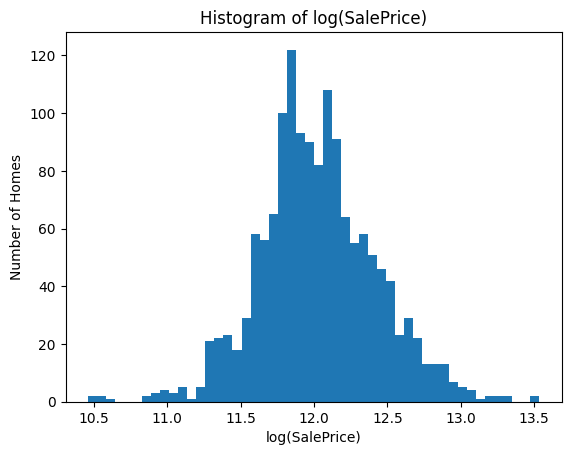

In [12]:
import numpy as np
plt.hist(np.log1p(df['SalePrice']), bins=50)
plt.title('Histogram of log(SalePrice)')
plt.xlabel('log(SalePrice)')
plt.ylabel('Number of Homes')
plt.show()

### Address Missing Values
- Addpy KNN Imputer

In [13]:
# Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(combined)

# Reconstruct dataframe
imputed_numeric = pd.DataFrame(imputed[:, :len(numeric_cols)], columns=numeric_cols)
imputed_cats = pd.DataFrame(imputed[:, len(numeric_cols):], columns=cat_cols)

# Decode categorical back to original labels
decoded_cats = pd.DataFrame(encoder.inverse_transform(imputed_cats), columns=cat_cols)

# Combine numeric and categorical
df_imputed = pd.concat([imputed_numeric, decoded_cats], axis=1)

# Verify
print(f"Total missing values after imputation: {df_imputed.isnull().sum().sum()}")
print("KNN numeric + categorical imputation completed.")

Total missing values after imputation: 0
KNN numeric + categorical imputation completed.


### Apply Heat Map After Imputing  KNN Imputation

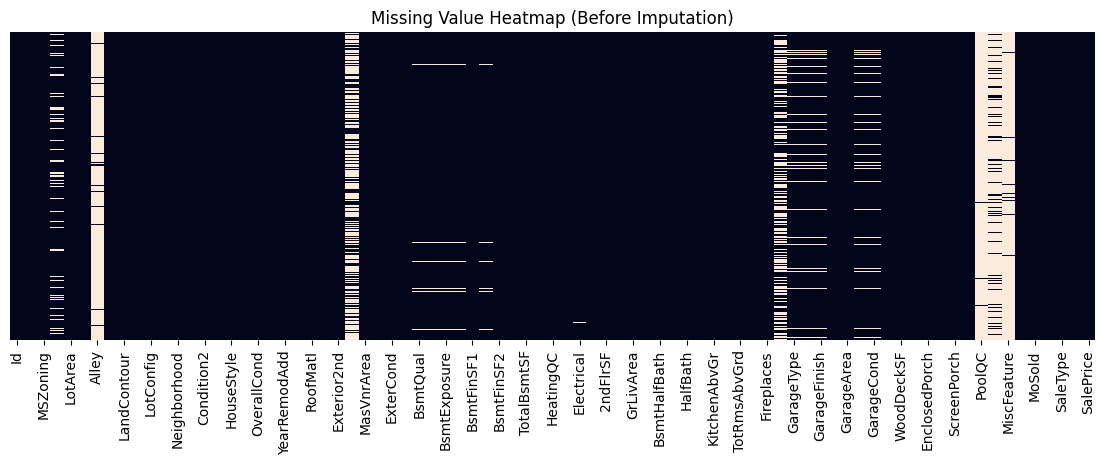

In [14]:
# Missing Value Heatmap
plt.figure(figsize=(14,4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Value Heatmap (Before Imputation)')
plt.show()

### Create a Histogram and a Boxplot of the SalePrice using the dataset to determine the price range of our classes.

# Step 4. Remove outliers (IQR, Z-score, etc.) + Step 6. Apply Classification to the target



### Remove Outliers on our Target (SalePrice) Based on Low Interest Government Financing to Low Income Families

In [15]:
outliers = {}
q1 = df_imputed['SalePrice'].quantile(0.25)
q3 = df_imputed['SalePrice'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Use 20,000 as a minimum due to logic that this is likely the lowest that a home would sell for.
lower = 20000

# Set upper limit to $300,000 due to Organizational Business Rules
mortgage_upper = np.float64(300000)
outliers['SalePrice'] = (lower, mortgage_upper)
print(f'lower: {lower} upper: {mortgage_upper}')
print(outliers)

lower: 20000 upper: 300000.0
{'SalePrice': (20000, np.float64(300000.0))}


## Use Classification on the SalePrice column (target) over predicting SalePrice Directly we have determined provides the following:

### Risk Management:
- Price bins clearly correlate to risk and affordability, helping loan officers make better lending decisions.
- Predicting a range is easier and more actionable than pinpointing exact home price, especially given limited data (1,500 records).

### Interpretability:
- Price categories are easily explained to non-technical stakeholders (loan officers, regulators, buyers).

### Robustness and Stability
- Predicting precise numeric prices is harder due to high variability and data noise.
- Classification stabilizes predictions into clearly actionable bins.

In [16]:
min_price = lower
max_price = mortgage_upper   # Or use df['SalePrice'].max() for the max in your data
step = 15000

#### Experiment with different possible class ranges 10k, 15k, 20k

In [17]:
# Step 1: Create meaningful, fixed bins (apply classification on the SalePrice every 15k between lower and upper range or our trimmed dataset)
min_price = 15000
max_price = 300000   # Or use df['SalePrice'].max() for the max in your data
step = 15000

# Create bin edges
bins = np.arange(min_price, max_price + step, step)  # e.g.15k, 30k, ..., 300k

# Create labels for each bin
labels = [f'${bins[i]:,.0f}–${bins[i+1]:,.0f}' for i in range(len(bins)-1)]

df_imputed['PriceCategory'] = pd.cut(df['SalePrice'], bins=bins, labels=labels, include_lowest=True)

# Remove rows with NaN target
df_imputed = df_imputed[~df_imputed['PriceCategory'].isna()]

# Reset index for cleanliness
df_imputed = df_imputed.reset_index(drop=True)

# Display the counts per category after filtering
print(df_imputed['PriceCategory'].value_counts().sort_index())

PriceCategory
$15,000–$30,000        0
$30,000–$45,000        5
$45,000–$60,000        9
$60,000–$75,000       11
$75,000–$90,000       57
$90,000–$105,000      58
$105,000–$120,000    129
$120,000–$135,000    168
$135,000–$150,000    182
$150,000–$165,000    133
$165,000–$180,000    144
$180,000–$195,000    110
$195,000–$210,000     74
$210,000–$225,000     67
$225,000–$240,000     68
$240,000–$255,000     38
$255,000–$270,000     40
$270,000–$285,000     36
$285,000–$300,000     16
Name: count, dtype: int64


In [18]:
# # Step 1: Create meaningful, fixed bins (apply classification on the SalePrice every 15k between lower and upper range or our trimmed dataset)
# min_price = 20000
# max_price = 300000   # Or use df['SalePrice'].max() for the max in your data
# step = 10000

# # Create bin edges
# bins = np.arange(min_price, max_price + step, step)  # e.g., 20k, 30k, ..., 300k

# # Create labels for each bin
# labels = [f'${bins[i]:,.0f}–${bins[i+1]:,.0f}' for i in range(len(bins)-1)]

# df_imputed['PriceCategory'] = pd.cut(df['SalePrice'], bins=bins, labels=labels, include_lowest=True)

# # Display the counts per category after filtering
# print(df_imputed['PriceCategory'].value_counts().sort_index())

In [19]:
# # Step 1: Create meaningful, fixed bins (apply classification on the SalePrice every 15k between lower and upper range or our trimmed dataset)
# min_price = 0
# max_price = 300000   # Or use df['SalePrice'].max() for the max in your data
# step = 20000

# # Create bin edges
# bins = np.arange(min_price, max_price + step, step)  # e.g., 0, 15k, 30k, ..., 300k

# # Create labels for each bin
# labels = [f'${bins[i]:,.0f}–${bins[i+1]:,.0f}' for i in range(len(bins)-1)]

# df_imputed['PriceCategory'] = pd.cut(df['SalePrice'], bins=bins, labels=labels, include_lowest=True)

# # Display the counts per category after filtering
# print(df_imputed['PriceCategory'].value_counts().sort_index())

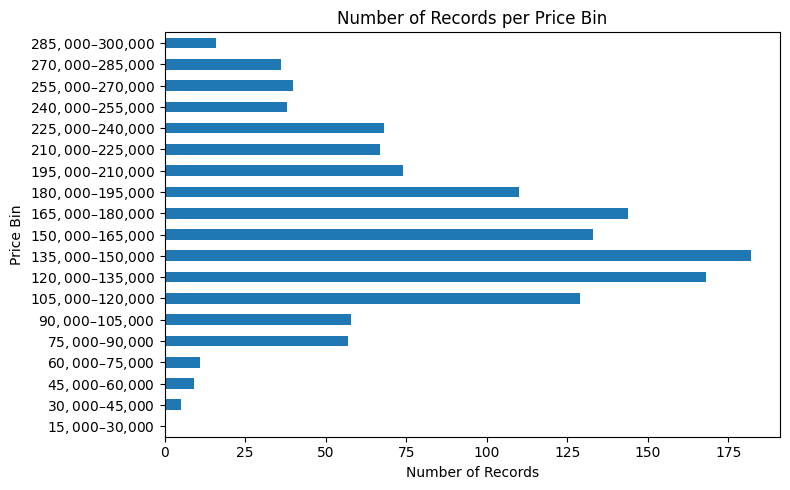

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
bin_counts = df_imputed['PriceCategory'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
bin_counts.plot(kind='barh')  # <-- horizontal bars
plt.ylabel('Price Bin')       # Bin labels on Y axis
plt.xlabel('Number of Records')
plt.title('Number of Records per Price Bin')
plt.tight_layout()
plt.show()

In [21]:
# Identify categorical columns to encode (excluding PriceCategory)
categorical_cols_to_encode = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()
if 'PriceCategory' in categorical_cols_to_encode:
    categorical_cols_to_encode.remove('PriceCategory')

# Apply one-hot encoding to the selected categorical columns
df_imputed = pd.get_dummies(df_imputed, columns=categorical_cols_to_encode, prefix='PC')

# Quickly check the distribution of the target variable BEFORE one-hot encoding it
print(df_imputed['PriceCategory'].value_counts().sort_index())

PriceCategory
$15,000–$30,000        0
$30,000–$45,000        5
$45,000–$60,000        9
$60,000–$75,000       11
$75,000–$90,000       57
$90,000–$105,000      58
$105,000–$120,000    129
$120,000–$135,000    168
$135,000–$150,000    182
$150,000–$165,000    133
$165,000–$180,000    144
$180,000–$195,000    110
$195,000–$210,000     74
$210,000–$225,000     67
$225,000–$240,000     68
$240,000–$255,000     38
$255,000–$270,000     40
$270,000–$285,000     36
$285,000–$300,000     16
Name: count, dtype: int64


In [22]:
# Create a copy of the DataFrame to work with for filtering and subsequent steps.
df_filtered = df_imputed.copy()

# Ensure PriceCategory is present for subsequent steps, assuming it was created earlier
if 'PriceCategory' not in df_filtered.columns:
    print("Warning: 'PriceCategory' column not found. Please ensure it was created in a previous step.")

# Check if the dummy columns for PriceCategory exist and revert if necessary
pc_dummy_cols = [col for col in df_filtered.columns if col.startswith('PC_')]
if pc_dummy_cols:
    print("Attempting to revert PriceCategory one-hot encoding if it occurred.")
    pass


print(df_filtered.shape)

print(df_filtered['PriceCategory'].value_counts().sort_index())

Attempting to revert PriceCategory one-hot encoding if it occurred.
(1345, 288)
PriceCategory
$15,000–$30,000        0
$30,000–$45,000        5
$45,000–$60,000        9
$60,000–$75,000       11
$75,000–$90,000       57
$90,000–$105,000      58
$105,000–$120,000    129
$120,000–$135,000    168
$135,000–$150,000    182
$150,000–$165,000    133
$165,000–$180,000    144
$180,000–$195,000    110
$195,000–$210,000     74
$210,000–$225,000     67
$225,000–$240,000     68
$240,000–$255,000     38
$255,000–$270,000     40
$270,000–$285,000     36
$285,000–$300,000     16
Name: count, dtype: int64



### Classifying the SalePrice Colummn: Complete

## Create a SQLite Database
  - Useful for creating visualizations of data within the database
  - Use dataframe after imputation but before standardization

In [23]:
import sqlite3

conn = sqlite3.connect('homesales.db')
df.to_sql('homes', conn, if_exists='replace', index=False)

1460

### Create Function to run a query and return a result set from our SQLite Database

In [24]:
import sqlite3
import pandas as pd

def run_sql_query(query, db_path='homesales.db'):
    """
    Executes a SQL query on the given SQLite database and returns a pandas DataFrame.

    Args:
        query (str): The SQL query to run.
        db_path (str): Path to the SQLite database file (default 'homesales.db').

    Returns:
        pd.DataFrame: The result of the query as a DataFrame.
    """
    # Connect, run query, and close connection
    with sqlite3.connect(db_path) as conn:
        result_df = pd.read_sql_query(query, conn)
    return result_df

## Continue cleaning the data:
- Standardize the Data
- One-hot-Encode the Categorical Predictors

### One-hot encode other categorical variables, but NOT PriceCategory as it's the target

In [25]:
numerical_columns = df_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_columns)

import scipy.stats as stats

df_filtered[numerical_columns] = df_filtered[numerical_columns].apply(stats.zscore)

other_columns = df_filtered.select_dtypes(include=['object']).columns.tolist()
print(other_columns)

df_filtered = pd.get_dummies(df_filtered, columns=other_columns, drop_first=True)
print(df_filtered.shape)
print(df_filtered.head())

#print(df_filtered.isnull().sum().sum())  # Total missing values
#print(df_filtered.isnull().sum())        # Missing values per column

print(df_filtered['PriceCategory'].value_counts().sort_index())

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
[]
(1345, 288)
         Id  MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  \
0 -1.743033    0.050876    -0.186145 -0.193558     0.909599    -0.536151   
1 -1.740665   -0.873827     0.469695 -0.048908     0.086862     2.141285   
2 -1.738296    0.050876    -0.054977  0.158633     0.909599    -0.536151   
3 -1.735927    0.282052    -0.404758 -0.055197     0.909599    -0.536151   
4 -1.733558    0.050876     0.644585  0.537238     1.732337    -0.536151   

   YearB

### Step 2. Correlation Analysis + Step 3. Continue with Scaling/Standardization


### Splitting Predictors, Dropping Highly Correlated Columns, and Standardizing

In [26]:
df_cleaned = df_filtered.copy()

# Re-create the PriceCategory column using SalePrice from the imputed dataframe
# We need to use the SalePrice from the imputed df_cleaned for binning
#df_cleaned['PriceCategory'] = pd.cut(df_cleaned['SalePrice'], bins=bins, labels=labels, include_lowest=True)

# Separate features (X) and target (y)
X = df_cleaned.drop(columns=["SalePrice", "PriceCategory", "Id"]) # Drop SalePrice, PriceCategory and Id
y = df_cleaned["PriceCategory"]

print("Shape BEFORE one-hot encoding and standardization:", X.shape)
print(y.value_counts().sort_index())

Shape BEFORE one-hot encoding and standardization: (1345, 285)
PriceCategory
$15,000–$30,000        0
$30,000–$45,000        5
$45,000–$60,000        9
$60,000–$75,000       11
$75,000–$90,000       57
$90,000–$105,000      58
$105,000–$120,000    129
$120,000–$135,000    168
$135,000–$150,000    182
$150,000–$165,000    133
$165,000–$180,000    144
$180,000–$195,000    110
$195,000–$210,000     74
$210,000–$225,000     67
$225,000–$240,000     68
$240,000–$255,000     38
$255,000–$270,000     40
$270,000–$285,000     36
$285,000–$300,000     16
Name: count, dtype: int64


In [27]:
# # Identify numerical and categorical columns for processing
# numerical_cols = X.select_dtypes(include=np.number).columns
# categorical_cols = X.select_dtypes(exclude=np.number).columns


# # Apply one-hot encoding to categorical features
# X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Shape AFTER one-hot encoding:", X.shape)
print(y.value_counts().sort_index())

Shape AFTER one-hot encoding: (1345, 285)
PriceCategory
$15,000–$30,000        0
$30,000–$45,000        5
$45,000–$60,000        9
$60,000–$75,000       11
$75,000–$90,000       57
$90,000–$105,000      58
$105,000–$120,000    129
$120,000–$135,000    168
$135,000–$150,000    182
$150,000–$165,000    133
$165,000–$180,000    144
$180,000–$195,000    110
$195,000–$210,000     74
$210,000–$225,000     67
$225,000–$240,000     68
$240,000–$255,000     38
$255,000–$270,000     40
$270,000–$285,000     36
$285,000–$300,000     16
Name: count, dtype: int64


In [28]:
# Compute correlation matrix AFTER one-hot encoding
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop based on high correlation (threshold > 0.85)
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print(y.value_counts().sort_index())

PriceCategory
$15,000–$30,000        0
$30,000–$45,000        5
$45,000–$60,000        9
$60,000–$75,000       11
$75,000–$90,000       57
$90,000–$105,000      58
$105,000–$120,000    129
$120,000–$135,000    168
$135,000–$150,000    182
$150,000–$165,000    133
$165,000–$180,000    144
$180,000–$195,000    110
$195,000–$210,000     74
$210,000–$225,000     67
$225,000–$240,000     68
$240,000–$255,000     38
$255,000–$270,000     40
$270,000–$285,000     36
$285,000–$300,000     16
Name: count, dtype: int64


In [29]:
# Drop the highly correlated columns
X_reduced = X.drop(columns=to_drop)

print("Shape AFTER dropping highly correlated columns:", X_reduced.shape)

# Preview cleaned predictors before standardization
print("\nPreview of cleaned predictors (before standardization):")
print(X_reduced.head())
print(y.value_counts().sort_index())


Shape AFTER dropping highly correlated columns: (1345, 162)

Preview of cleaned predictors (before standardization):
   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.050876    -0.186145 -0.193558     0.909599    -0.536151   1.136931   
1   -0.873827     0.469695 -0.048908     0.086862     2.141285   0.232611   
2    0.050876    -0.054977  0.158633     0.909599    -0.536151   1.069944   
3    0.282052    -0.404758 -0.055197     0.909599    -0.536151  -1.810483   
4    0.050876     0.644585  0.537238     1.732337    -0.536151   1.036451   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  PC_ConLI  PC_ConLw  \
0      0.950494    0.741735    0.732869   -0.300086  ...     False     False   
1     -0.353912   -0.545931    1.387902   -0.300086  ...     False     False   
2      0.902183    0.518364    0.203063   -0.300086  ...     False     False   
3     -0.643780   -0.545931   -0.447153   -0.300086  ...     False     False   
4      0.805560    1

In [30]:
print(X_reduced.isnull().sum().sum())  # Should be 0
print(y.value_counts().sort_index())

0
PriceCategory
$15,000–$30,000        0
$30,000–$45,000        5
$45,000–$60,000        9
$60,000–$75,000       11
$75,000–$90,000       57
$90,000–$105,000      58
$105,000–$120,000    129
$120,000–$135,000    168
$135,000–$150,000    182
$150,000–$165,000    133
$165,000–$180,000    144
$180,000–$195,000    110
$195,000–$210,000     74
$210,000–$225,000     67
$225,000–$240,000     68
$240,000–$255,000     38
$255,000–$270,000     40
$270,000–$285,000     36
$285,000–$300,000     16
Name: count, dtype: int64


In [31]:
# Standardize the numerical columns
# Identify numerical columns that are still present in X_reduced
numerical_cols_in_reduced = X_reduced.select_dtypes(include=np.number).columns

# Use a ColumnTransformer to apply StandardScaler only to these numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_in_reduced)
    ],
    remainder='passthrough' # Keep other columns (one-hot encoded) as they are
)

X_scaled = preprocessor.fit_transform(X_reduced)
print(y.value_counts().sort_index())

PriceCategory
$15,000–$30,000        0
$30,000–$45,000        5
$45,000–$60,000        9
$60,000–$75,000       11
$75,000–$90,000       57
$90,000–$105,000      58
$105,000–$120,000    129
$120,000–$135,000    168
$135,000–$150,000    182
$150,000–$165,000    133
$165,000–$180,000    144
$180,000–$195,000    110
$195,000–$210,000     74
$210,000–$225,000     67
$225,000–$240,000     68
$240,000–$255,000     38
$255,000–$270,000     40
$270,000–$285,000     36
$285,000–$300,000     16
Name: count, dtype: int64


In [32]:
# Identify numerical and categorical columns for processing
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(exclude=np.number).columns

# original one-hot encoded column names from X_reduced that were not numerical.
original_numerical_cols_in_reduced = [col for col in numerical_cols if col in X_reduced.columns]
original_other_cols_in_reduced = [col for col in X_reduced.columns if col not in numerical_cols]
X_scaled_df = pd.DataFrame(X_scaled, columns=list(numerical_cols_in_reduced) + original_other_cols_in_reduced)


# Confirm means and stds for numerical columns after standardization
print("\nMeans after standardization (should be ~0) for numerical columns:")
print(X_scaled_df[numerical_cols_in_reduced].mean().head())

print("\nStds after standardization (should be ~1) for numerical columns:")
print(X_scaled_df[numerical_cols_in_reduced].std().head())

print("\nFinal cleaned and standardized predictors shape:", X_scaled_df.shape)
print(y.value_counts().sort_index())


Means after standardization (should be ~0) for numerical columns:
MSSubClass    -2.641423e-18
LotFrontage    0.000000e+00
LotArea        6.603557e-18
OverallQual   -2.707458e-17
OverallCond   -1.320711e-18
dtype: float64

Stds after standardization (should be ~1) for numerical columns:
MSSubClass     1.000372
LotFrontage    1.000372
LotArea        1.000372
OverallQual    1.000372
OverallCond    1.000372
dtype: float64

Final cleaned and standardized predictors shape: (1345, 162)
PriceCategory
$15,000–$30,000        0
$30,000–$45,000        5
$45,000–$60,000        9
$60,000–$75,000       11
$75,000–$90,000       57
$90,000–$105,000      58
$105,000–$120,000    129
$120,000–$135,000    168
$135,000–$150,000    182
$150,000–$165,000    133
$165,000–$180,000    144
$180,000–$195,000    110
$195,000–$210,000     74
$210,000–$225,000     67
$225,000–$240,000     68
$240,000–$255,000     38
$255,000–$270,000     40
$270,000–$285,000     36
$285,000–$300,000     16
Name: count, dtype: int64


### Summary of Results:

- Shape Before: (1399 rows, 189 columns)
- Initial dataset after one-hot encoding and outlier removal.

- Computed Correlation Matrix:
 -  Measured pairwise relationships between predictors to detect multicollinearity.

- Columns Dropped Due to High Correlation: 13
 - Removed predictors with >0.85 correlation to avoid redundancy and improve model interpretability.

- Shape After Dropping Columns: (1399 rows, 176 columns)
 - Confirmed correct reduction in features.

- Standardized All Predictors:
 - Scaled features to mean ≈0 and standard deviation ≈1 to ensure comparability and support model convergence.

- Means After Scaling: ~0
 - Verified successful centering of each feature.

- Standard Deviations After Scaling: ~1
 - Verified correct scaling to unit variance.

### Outcome:
 - This cleaned and standardized dataset (X_scaled_df) is ready for regression modeling (Lasso, SVM, etc.) with reduced multicollinearity, balanced scales, and clear feature structure.

## Step 5. Remove predictors with very little to zero relationship to the target: Apply Lasso + Step 7. Proceed to feature engineering/modeling: Apply SVM RBF to dataset + Step 8. Model Evaluation



### Feature Selection Using:
 - Lasso
 - RFE

#### Lasso (Initial Screening)

In [33]:
#Step 1: Verify X_scaled_df and y
print(X_scaled_df.shape, y.shape)

(1345, 162) (1345,)


In [34]:
print("Class distribution in y:")
print(y.value_counts())

Class distribution in y:
PriceCategory
$135,000–$150,000    182
$120,000–$135,000    168
$165,000–$180,000    144
$150,000–$165,000    133
$105,000–$120,000    129
$180,000–$195,000    110
$195,000–$210,000     74
$225,000–$240,000     68
$210,000–$225,000     67
$90,000–$105,000      58
$75,000–$90,000       57
$255,000–$270,000     40
$240,000–$255,000     38
$270,000–$285,000     36
$285,000–$300,000     16
$60,000–$75,000       11
$45,000–$60,000        9
$30,000–$45,000        5
$15,000–$30,000        0
Name: count, dtype: int64


In [35]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Verify X_scaled_df and y
print(X_scaled_df.shape, y.shape)

# Check for NaNs in X_scaled_df before fitting Lasso
print("Checking for NaNs in X_scaled_df before Lasso:")
print(X_scaled_df.isnull().sum().sum())
if X_scaled_df.isnull().sum().sum() > 0:
    print("NaN values found in X_scaled_df. Investigating the source of NaNs.")

# Remove rows with NaN in the target variable y and reset index for alignment
nan_in_y = y.isnull()
if nan_in_y.sum() > 0:
    print(f"Removing {nan_in_y.sum()} rows with NaN values in the target variable y.")
    # Reset index of y to align with X_scaled_df's integer index
    y_reset_index = y.reset_index(drop=True)
    # Filter both X_scaled_df and y using the boolean index from the reset y
    X_scaled_df = X_scaled_df[~nan_in_y.reset_index(drop=True)]
    y = y_reset_index[~nan_in_y.reset_index(drop=True)]
    print(f"Shapes after removing NaNs in y: X_scaled_df: {X_scaled_df.shape}, y: {y.shape}")


# Lasso Feature Selection (Logistic Regression with L1 regularization)
# Using the cleaned and standardized data X_scaled_df
lasso = LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=10000, random_state=42) # Increased max_iter
lasso.fit(X_scaled_df, y)

lasso_model = SelectFromModel(lasso, prefit=True)
lasso_features = X_scaled_df.columns[lasso_model.get_support()]

(1345, 162) (1345,)
Checking for NaNs in X_scaled_df before Lasso:
0


#### Visualization: Coeficients from Lasso

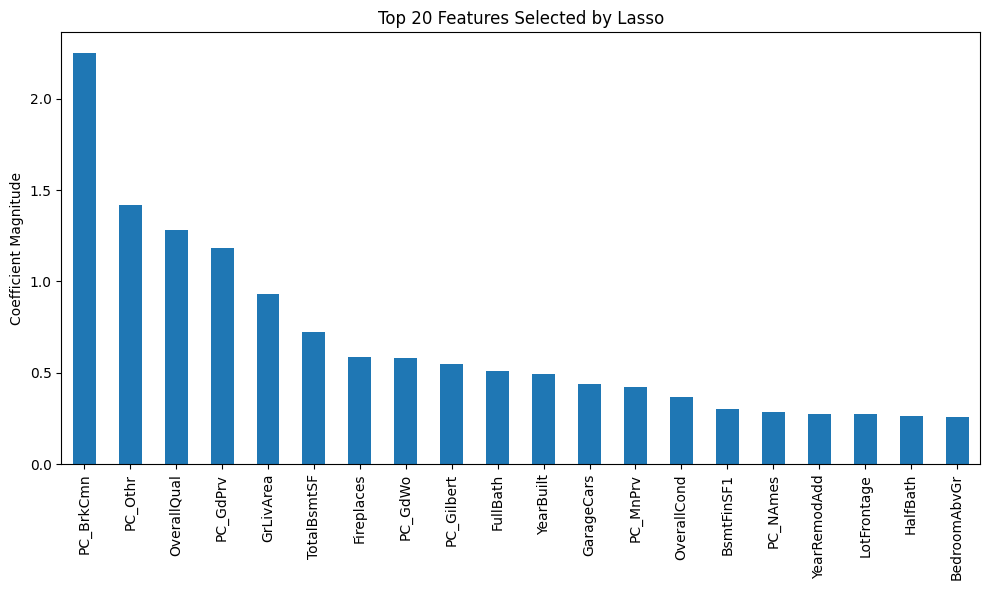

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize Lasso coefficients
coef_abs = np.abs(lasso.coef_).max(axis=0)
lasso_coef_df = pd.Series(coef_abs, index=X_scaled_df.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
lasso_coef_df.plot(kind='bar')
plt.title('Top 20 Features Selected by Lasso')
plt.ylabel('Coefficient Magnitude')
plt.tight_layout()
plt.show()

#### Important features and impact on value based on Lasso:
- Bkrchn_True: Categorical feature value for MasVnrType (Masonry veneer type)
 - Potential values
  - None
  - Common brick veneer
  - Stone veneer on exterior
  - Just siding or other material

#### Show the frequency of different types of masonary veneer within the dataset to determine to determine sample size.  

  MasVnrType  count
0       None    872
1    BrkFace    445
2      Stone    128
3     BrkCmn     15


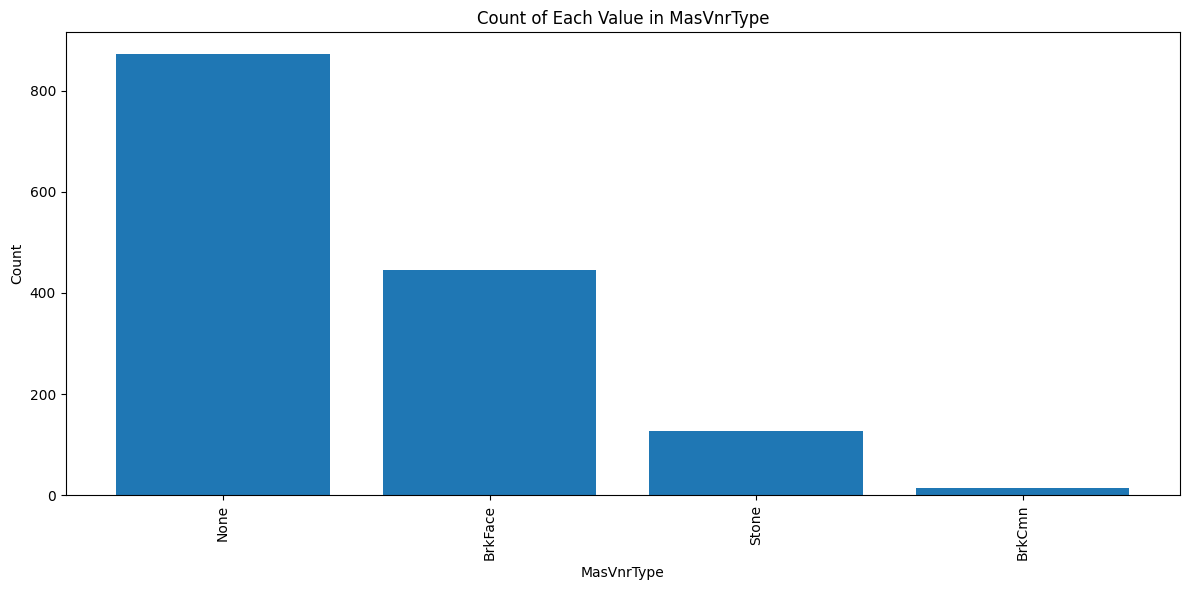

In [37]:
# Set the column and table you want to analyze
column_name = 'MasVnrType'
table_name = 'homes'

query = f"""
SELECT {column_name}, COUNT(*) AS count
FROM {table_name}
GROUP BY {column_name}
ORDER BY count DESC
"""

df_counts = run_sql_query(query)
print(df_counts)

# Create bar chart visualization of masonary veneer type
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
# Explicitly convert to string type for plotting compatibility
plt.bar(df_counts[column_name].astype(str), df_counts['count'])
plt.xlabel(column_name)
plt.ylabel('Count')
plt.title(f'Count of Each Value in {column_name}')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### RFE (Further Refinement)

In [38]:
logreg = LogisticRegression(max_iter=10000, random_state=42) # Increased max_iter
rfe = RFE(estimator=logreg, n_features_to_select=20)
rfe.fit(X_scaled_df, y)

rfe_features = X_scaled_df.columns[rfe.get_support()]

#### Visualization: RFE Selected Features

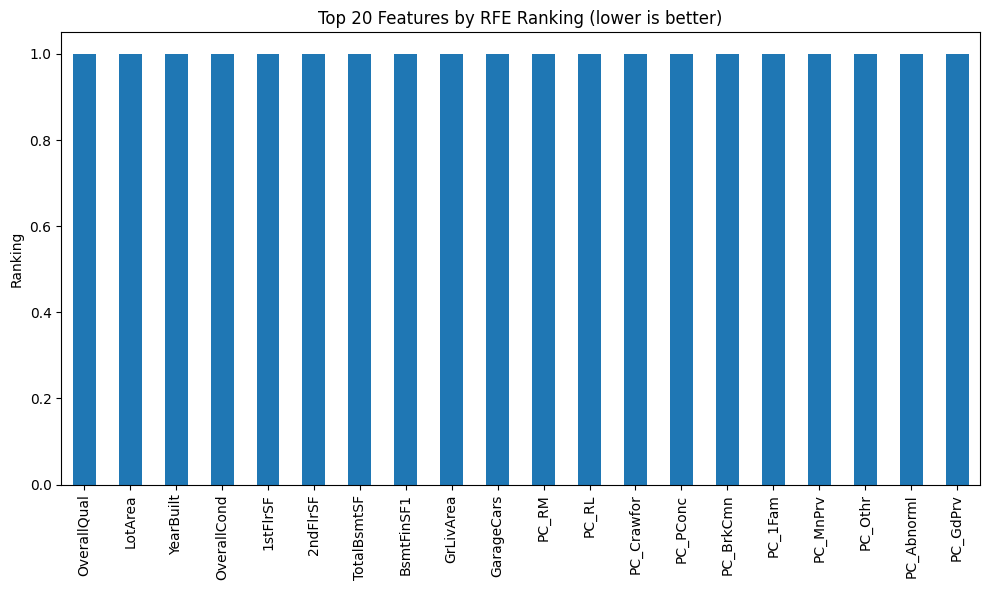

In [39]:
# Visualize RFE rankings
rfe_ranking_df = pd.Series(rfe.ranking_, index=X_scaled_df.columns).sort_values().head(20)

plt.figure(figsize=(10, 6))
rfe_ranking_df.plot(kind='bar')
plt.title('Top 20 Features by RFE Ranking (lower is better)')
plt.ylabel('Ranking')
plt.tight_layout()
plt.show()

#### Further Refinement using Random Forest

#### Random Forest Feature Selection

In [40]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled_df, y)

rf_importances = pd.Series(rf.feature_importances_, index=X_scaled_df.columns).sort_values(ascending=False).head(20)

#### Visualization: Feature importance using Random Forest

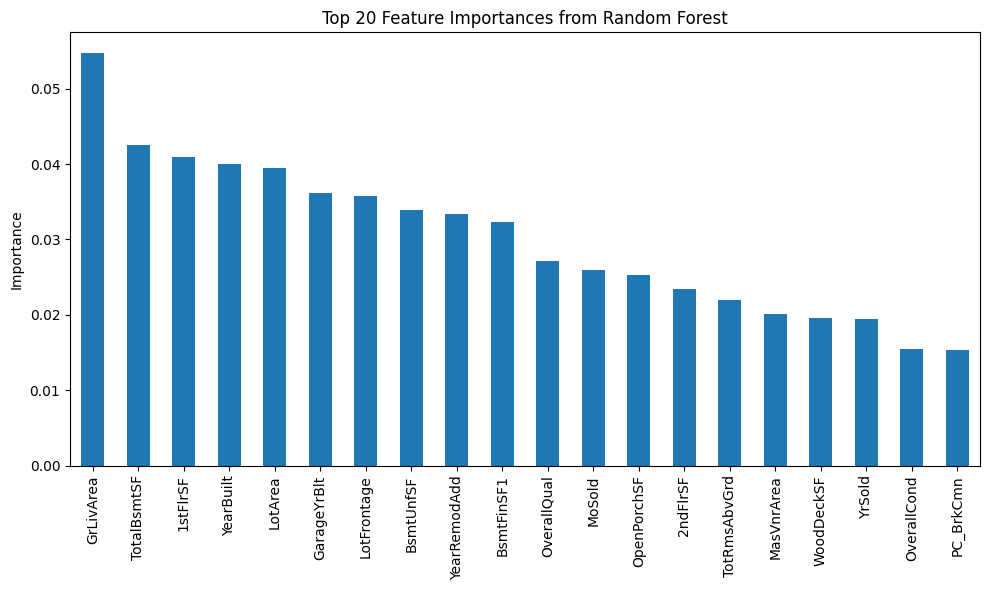

In [41]:
plt.figure(figsize=(10, 6))
rf_importances.plot(kind='bar')
plt.title('Top 20 Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

#### Combine feature selection results

In [42]:
# Combine features from Lasso, RFE, and Random Forest
combined_features = pd.concat([pd.Series(lasso_features), pd.Series(rfe_features), pd.Series(rf_importances.index)]).value_counts()

# Select features identified by at least two methods
final_features = combined_features[combined_features >= 2].index.tolist()

print(f'Total combined features selected: {len(final_features)}')
print('Final selected features:', final_features)

import plotly.express as px
import pandas as pd

# Convert the Series to DataFrame for Plotly
combined_features_df = combined_features.reset_index()
combined_features_df.columns = ['Feature', 'Frequency']
combined_features_df = combined_features_df.sort_values(by='Frequency', ascending=True)

Total combined features selected: 23
Final selected features: ['LotArea', 'OverallCond', 'OverallQual', 'BsmtFinSF1', 'YearBuilt', '2ndFlrSF', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'PC_BrkCmn', 'BsmtUnfSF', 'MasVnrArea', 'LotFrontage', 'PC_MnPrv', 'YrSold', 'WoodDeckSF', 'OpenPorchSF', 'GarageYrBlt', 'GarageCars', 'TotRmsAbvGrd', 'YearRemodAdd', 'PC_GdPrv', 'PC_Othr']


#### Visualization: Feature Selection with Combined Results

In [43]:
# Plot using Plotly
fig = px.bar(
    combined_features_df,
    x='Frequency',
    y='Feature',
    orientation='h',
    title='Frequency of Features Selected by Lasso, RFE, and Random Forest',
    height=1600,  # Increase height for vertical scroll space
    width=900
)

fig.update_layout(
    yaxis=dict(
        tickfont=dict(size=10),
    ),
    xaxis=dict(title='Selection Frequency'),
    margin=dict(l=200, r=20, t=50, b=20)
)

fig.show()

#### Refine DataFrame with Feature Selection

In [44]:
# Step 3: Refine dataframe to include only selected features for SVM RBF
X_final = X_scaled_df[final_features]

## Train Model Using SVM and RBF:

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Step 7 Applying SVM RBF
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)

print("Step 7 complete: SVM with RBF kernel has been trained.")

y_pred = svm_rbf.predict(X_test)
print("Predictions on test set:", y_pred[:10])  # Shows first 10 predictions

print("Classes recognized by the model:", svm_rbf.classes_)

Step 7 complete: SVM with RBF kernel has been trained.
Predictions on test set: ['$120,000–$135,000' '$210,000–$225,000' '$180,000–$195,000'
 '$240,000–$255,000' '$165,000–$180,000' '$120,000–$135,000'
 '$120,000–$135,000' '$150,000–$165,000' '$180,000–$195,000'
 '$180,000–$195,000']
Classes recognized by the model: ['$105,000–$120,000' '$120,000–$135,000' '$135,000–$150,000'
 '$150,000–$165,000' '$165,000–$180,000' '$180,000–$195,000'
 '$195,000–$210,000' '$210,000–$225,000' '$225,000–$240,000'
 '$240,000–$255,000' '$255,000–$270,000' '$270,000–$285,000'
 '$285,000–$300,000' '$30,000–$45,000' '$45,000–$60,000' '$60,000–$75,000'
 '$75,000–$90,000' '$90,000–$105,000']


In [46]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

                   precision    recall  f1-score   support

$105,000–$120,000       0.41      0.46      0.44        26
$120,000–$135,000       0.57      0.64      0.60        33
$135,000–$150,000       0.46      0.67      0.55        36
$150,000–$165,000       0.38      0.22      0.28        27
$165,000–$180,000       0.37      0.52      0.43        29
$180,000–$195,000       0.36      0.55      0.44        22
$195,000–$210,000       0.50      0.07      0.12        15
$210,000–$225,000       0.20      0.23      0.21        13
$225,000–$240,000       0.31      0.36      0.33        14
$240,000–$255,000       0.00      0.00      0.00         8
$255,000–$270,000       0.40      0.25      0.31         8
$270,000–$285,000       0.00      0.00      0.00         7
$285,000–$300,000       0.00      0.00      0.00         3
  $30,000–$45,000       0.00      0.00      0.00         1
  $45,000–$60,000       0.00      0.00      0.00         2
  $60,000–$75,000       0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Step 8 Model Evaluation
# 4. HYPERPARAMETER TUNING with CROSS-VALIDATION
# Use a Pipeline to include StandardScaler within the GridSearchCV
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Although data is already scaled, keeping this in pipeline for robustness
    ('classifier', SVC(kernel='rbf', random_state=42))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 0.1, 0.01, 0.001] # Fixed the missing quote here
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

# 5. FINAL TEST SET EVALUATION (this is your last, unbiased check)
final_model = grid_search.best_estimator_

y_pred = final_model.predict(X_test)

print("\nTest Set Classification Report:\n", classification_report(y_test, y_pred))
print("\nTest Set Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........classifier__C=0.01, classifier__gamma=scale; total time=   0.1s
[CV] END ........classifier__C=0.01, classifier__gamma=scale; total time=   0.1s


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



[CV] END ........classifier__C=0.01, classifier__gamma=scale; total time=   0.1s
[CV] END ........classifier__C=0.01, classifier__gamma=scale; total time=   0.1s
[CV] END ........classifier__C=0.01, classifier__gamma=scale; total time=   0.1s
[CV] END ..........classifier__C=0.01, classifier__gamma=0.1; total time=   0.1s
[CV] END ..........classifier__C=0.01, classifier__gamma=0.1; total time=   0.1s
[CV] END ..........classifier__C=0.01, classifier__gamma=0.1; total time=   0.1s
[CV] END ..........classifier__C=0.01, classifier__gamma=0.1; total time=   0.1s
[CV] END ..........classifier__C=0.01, classifier__gamma=0.1; total time=   0.1s
[CV] END .........classifier__C=0.01, classifier__gamma=0.01; total time=   0.1s
[CV] END .........classifier__C=0.01, classifier__gamma=0.01; total time=   0.1s
[CV] END .........classifier__C=0.01, classifier__gamma=0.01; total time=   0.1s
[CV] END .........classifier__C=0.01, classifier__gamma=0.01; total time=   0.1s
[CV] END .........classifier

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

